In [35]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import shutil
import random
import sys
import time
import re

from textblob import TextBlob
from prettytable import PrettyTable

import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from prettytable import PrettyTable

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt


# Preprocessing the classifier data

In [36]:
# Importing the hatespeech dataset 

path_H_train='train_phobia.csv' 
path_H_test='test_phobia.csv' 
path_H_dev='val_phobia.csv'  


#Dataframe creation 
df_train = pd.read_csv(path_H_train)
df_test = pd.read_csv(path_H_test)
df_val = pd.read_csv(path_H_dev)



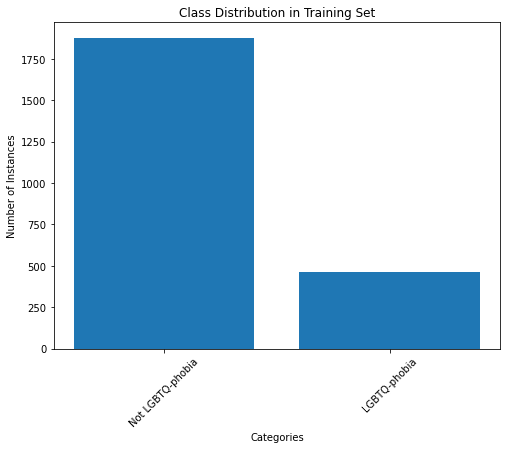

In [37]:
# Calculate the class distribution in the training set
class_counts_train = df_train['category'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts_train.index, class_counts_train.values)
plt.xlabel('Categories')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

In [38]:
# Balancing the dataset
# Calculate the class distribution in the training set
class_counts_train = df_train['category'].value_counts()

# Find the minority class label
minority_class_label = class_counts_train.idxmin()

# Get the indices of instances labeled as the minority class
minority_class_indices = df_train[df_train['category'] == minority_class_label].index

# Randomly select instances labeled as the majority class equal to the minority class count
majority_class_indices = df_train[df_train['category'] != minority_class_label].sample(n=len(minority_class_indices), random_state=42).index

# Concatenating the indices
balanced_indices = np.concatenate([minority_class_indices, majority_class_indices])

# Create the balanced training dataframe
df_train_balanced = df_train.loc[balanced_indices]

In [39]:
#preprocessing lemmatization

def preprocess(text):
    if isinstance(text, str):
        sentences = sent_tokenize(text)  # Tokenize into sentences
        sentences = [sent.lower() for sent in sentences]  # Convert to lowercase
        sentences = [re.sub(r"[^a-zA-Z0-9_ \n]", "", sent) for sent in sentences]  # Remove non-alphanumeric characters
        
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        
        lemmatized_sentences = []
        for sent in sentences:
            words = word_tokenize(sent)  # Tokenize into words
            lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stop words
            lemmatized_sentences.append(" ".join(lemmatized_words))  # Join the lemmatized words
            
        return ' '.join(lemmatized_sentences)  # Join the preprocessed sentences into a single string

In [40]:
#Training Set

df_train.dropna(subset=['category'], inplace=True)
df_train['test_case'] = df_train['test_case'].apply(preprocess)
df_train.dropna(subset=['test_case'], inplace=True)
df_train.head()

#Training Set Balanced

df_train_balanced.dropna(subset=['category'], inplace=True)
df_train_balanced['test_case'] = df_train_balanced['test_case'].apply(preprocess)
df_train_balanced.dropna(subset=['test_case'], inplace=True)
df_train_balanced.head()

#Test set

df_test.dropna(subset=['category'], inplace=True)
df_test['test_case']=df_test['test_case'].apply(preprocess)
df_test.dropna(subset=['test_case'], inplace=True)
df_test.head()

#Validation  set

df_val.dropna(subset=['category'], inplace=True)
df_val['test_case']= df_val['test_case'].apply(preprocess)
df_val.dropna(subset=['test_case'], inplace=True)
df_train.head()

,test_case,category
0,deathto woman,Not LGBTQ-phobia
1,far concerned disabled people go fuck,Not LGBTQ-phobia
2,honest fucked,Not LGBTQ-phobia
3,see get rid trans people,LGBTQ-phobia
4,error thinking gay life arent worth shit,LGBTQ-phobia


In [21]:
df_test['test_case'] = df_test['test_case'].apply(lambda x: x.split())
df_train['test_case'] = df_train['test_case'].apply(lambda x: x.split())
df_val['test_case'] = df_val['test_case'].apply(lambda x: x.split())


In [22]:
df_val.head()

,test_case,category
0,"[woman, make, happy]",Not LGBTQ-phobia
1,"[one, hope, someone, put, end, disabled, people]",Not LGBTQ-phobia
2,"[baffle, people, care, even, slightest, life, ...",Not LGBTQ-phobia
3,"[somebody, stab, balloon]",Not LGBTQ-phobia
4,"[really, okay, calling, people, faggot]",Not LGBTQ-phobia


# Training the N-gram models

In [23]:
#N-GRAM TRAINING

corpus_train = df_train['test_case'].apply(' '.join).tolist()
corpus_test = df_test['test_case'].apply(' '.join).tolist()
corpus_val = df_val['test_case'].apply(' '.join).tolist()


# Create unigram model using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))  # Unigram model
X_train_unigram = vectorizer.fit_transform(corpus_train)
X_test_unigram = vectorizer.transform(corpus_test)
X_val_unigram = vectorizer.transform(corpus_val)

# Create bigram models using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Bigram model
X_train_bigram = vectorizer.fit_transform(corpus_train)
X_test_bigram = vectorizer.transform(corpus_test)
X_val_bigram = vectorizer.transform(corpus_val)

# Create trigram models using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(3, 3))  # Trigram model
X_train_trigram = vectorizer.fit_transform(corpus_train)
X_test_trigram = vectorizer.transform(corpus_test)
X_val_trigram = vectorizer.transform(corpus_val)


y_train = df_train['category'].tolist()
y_test = df_test['category'].tolist()
y_val = df_val['category'].tolist()


# Train Logistic Regression on the unigram model
clf_unigram = LogisticRegression()
clf_unigram.fit(X_train_unigram, y_train)

# Train Logistic Regression on the bigram model
clf_bigram = LogisticRegression()
clf_bigram.fit(X_train_bigram, y_train)

# Train a classifier on the trigram model
clf_trigram = LogisticRegression()
clf_trigram.fit(X_train_trigram, y_train)



# Predict using the unigram model
y_test_pred_unigram = clf_unigram.predict(X_test_unigram)
y_val_pred_unigram = clf_unigram.predict(X_val_unigram)

# Predict using the bigram model
y_test_pred_bigram = clf_bigram.predict(X_test_bigram)
y_val_pred_bigram = clf_bigram.predict(X_val_bigram)

# Predict using the trigram model
y_test_pred_trigram = clf_trigram.predict(X_test_trigram)
y_val_pred_trigram = clf_trigram.predict(X_val_trigram)


In [24]:
#VALIDATION SET
# Calculate the evaluation metrics for unigram
val_accuracy_u = accuracy_score(df_val['category'].tolist(), y_val_pred_unigram)
val_precision_u = precision_score(df_val['category'].tolist(), y_val_pred_unigram, average='weighted', zero_division=1)
val_recall_u = recall_score(df_val['category'].tolist(), y_val_pred_unigram, average='weighted')
val_f1_u = f1_score(df_val['category'].tolist(), y_val_pred_unigram, average='weighted')

# Calculate the evaluation metrics for bigram
val_accuracy_b = accuracy_score(df_val['category'].tolist(), y_val_pred_bigram)
val_precision_b = precision_score(df_val['category'].tolist(), y_val_pred_bigram, average='weighted', zero_division=1)
val_recall_b = recall_score(df_val['category'].tolist(), y_val_pred_bigram, average='weighted')
val_f1_b = f1_score(df_val['category'].tolist(), y_val_pred_bigram, average='weighted')

# Calculate the evaluation metrics for trigram
val_accuracy_t = accuracy_score(df_val['category'].tolist(), y_val_pred_trigram)
val_precision_t = precision_score(df_val['category'].tolist(), y_val_pred_trigram, average='weighted', zero_division=1)
val_recall_t = recall_score(df_val['category'].tolist(), y_val_pred_trigram, average='weighted')
val_f1_t = f1_score(df_val['category'].tolist(), y_val_pred_trigram, average='weighted')


In [25]:
#TEST SET
# Calculate the evaluation metrics for unigram
accuracy_u = accuracy_score(df_test['category'].tolist(), y_test_pred_unigram)
precision_u = precision_score(df_test['category'].tolist(), y_test_pred_unigram, average='weighted', zero_division=1)
recall_u = recall_score(df_test['category'].tolist(), y_test_pred_unigram, average='weighted')
f1_u = f1_score(df_test['category'].tolist(), y_test_pred_unigram, average='weighted')

# Calculate the evaluation metrics for bigram
accuracy_b = accuracy_score(df_test['category'].tolist(), y_test_pred_bigram)
precision_b = precision_score(df_test['category'].tolist(), y_test_pred_bigram, average='weighted', zero_division=1)
recall_b = recall_score(df_test['category'].tolist(), y_test_pred_bigram, average='weighted')
f1_b = f1_score(df_test['category'].tolist(), y_test_pred_bigram, average='weighted')

# Calculate the evaluation metrics for trigram
accuracy_t = accuracy_score(df_test['category'].tolist(), y_test_pred_trigram)
precision_t = precision_score(df_test['category'].tolist(), y_test_pred_trigram, average='weighted', zero_division=1)
recall_t = recall_score(df_test['category'].tolist(), y_test_pred_trigram, average='weighted')
f1_t = f1_score(df_test['category'].tolist(), y_test_pred_trigram, average='weighted')


In [26]:
#Validation set evaluation metrics

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = [" ","Accuracy", "Precision", "Recall", "F1 Score"]

# Add the evaluation metrics for the trigram model to the table
table.add_row(["Unigram", val_accuracy_u, val_precision_u, val_recall_u, val_f1_u])

# Add the evaluation metrics for the bigram model to the table
table.add_row(["Bigram", val_accuracy_b, val_precision_b, val_recall_b, val_f1_b])

# Add the evaluation metrics for the trigram model to the table
table.add_row(["Trigram", val_accuracy_t, val_precision_t, val_recall_t, val_f1_t])


# Print the table
print("Validation set evaluation metrics:")
print(table)

Validation set evaluation metrics:
+---------+--------------------+--------------------+--------------------+--------------------+
|         |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+---------+--------------------+--------------------+--------------------+--------------------+
| Unigram | 0.9462227912932138 | 0.9494366916614381 | 0.9462227912932138 | 0.9472669658907981 |
|  Bigram | 0.9282970550576184 | 0.9286860674865453 | 0.9282970550576184 | 0.9284826573392091 |
| Trigram | 0.8181818181818182 | 0.7920721576074057 | 0.8181818181818182 | 0.7526791726791726 |
+---------+--------------------+--------------------+--------------------+--------------------+


In [27]:
#Test set evaluation metrics

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = [" ","Accuracy", "Precision", "Recall", "F1 Score"]

# Add the evaluation metrics for the trigram model to the table
table.add_row(["Unigram", accuracy_u, precision_u, recall_u, f1_u])

# Add the evaluation metrics for the bigram model to the table
table.add_row(["Bigram", accuracy_b, precision_b, recall_b, f1_b])

# Add the evaluation metrics for the trigram model to the table
table.add_row(["Trigram", accuracy_t, precision_t, recall_t, f1_t])


# Print the table
print("Test set evaluation metrics:")
print(table)

Test set evaluation metrics:
+---------+--------------------+--------------------+--------------------+--------------------+
|         |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+---------+--------------------+--------------------+--------------------+--------------------+
| Unigram | 0.941025641025641  | 0.9449758371709591 | 0.941025641025641  | 0.9423015285996056 |
|  Bigram | 0.9282051282051282 | 0.9282051282051282 | 0.9282051282051282 | 0.9282051282051282 |
| Trigram | 0.8320512820512821 | 0.8510784709603608 | 0.8320512820512821 | 0.7741639722284882 |
+---------+--------------------+--------------------+--------------------+--------------------+


Confusion Matrix for Unigram:


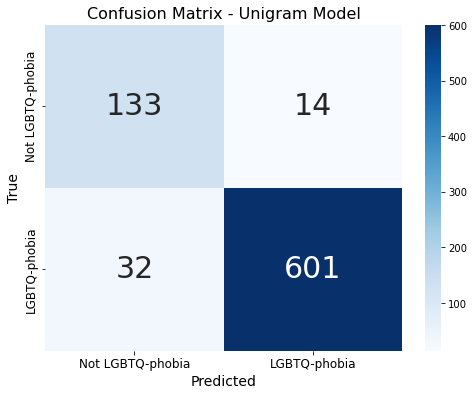

In [28]:
#Calculate the confusion matrix for unigram
cm_u = confusion_matrix(df_test['category'].tolist(), y_test_pred_unigram)
categories = df_train['category'].unique().tolist()

# Print the confusion matrix
print("Confusion Matrix for Unigram:")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_u, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories, annot_kws={"size": 30})
plt.xlabel('Predicted', fontsize=14)  # Increase font size of x-axis label
plt.ylabel('True', fontsize=14)  # Increase font size of y-axis label
plt.title('Confusion Matrix - Unigram Model', fontsize=16)  # Increase font size of title
plt.xticks(fontsize=12)  # Increase font size of x-axis tick labels
plt.yticks(fontsize=12)  # Increase font size of y-axis tick labels
plt.show()

Confusion Matrix for Bigram:


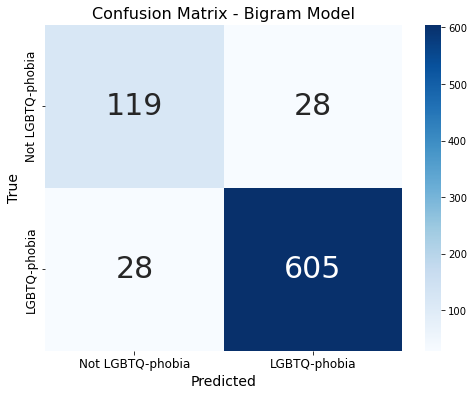

In [29]:
#Calculate the confusion matrix for bigram
cm_u = confusion_matrix(df_test['category'].tolist(), y_test_pred_bigram)
categories = df_train['category'].unique().tolist()

# Print the confusion matrix
print("Confusion Matrix for Bigram:")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_u, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories, annot_kws={"size": 30})
plt.xlabel('Predicted', fontsize=14)  # Increase font size of x-axis label
plt.ylabel('True', fontsize=14)  # Increase font size of y-axis label
plt.title('Confusion Matrix - Bigram Model', fontsize=16)  # Increase font size of title
plt.xticks(fontsize=12)  # Increase font size of x-axis tick labels
plt.yticks(fontsize=12)  # Increase font size of y-axis tick labels
plt.show()

Confusion Matrix for Trigram:


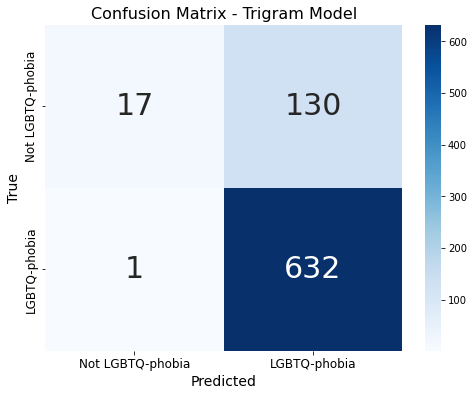

In [30]:
#Calculate the confusion matrix for bigram
cm_u = confusion_matrix(df_test['category'].tolist(), y_test_pred_trigram)
categories = df_train['category'].unique().tolist()

# Print the confusion matrix
print("Confusion Matrix for Trigram:")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_u, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories, annot_kws={"size": 30})
plt.xlabel('Predicted', fontsize=14)  # Increase font size of x-axis label
plt.ylabel('True', fontsize=14)  # Increase font size of y-axis label
plt.title('Confusion Matrix - Trigram Model', fontsize=16)  # Increase font size of title
plt.xticks(fontsize=12)  # Increase font size of x-axis tick labels
plt.yticks(fontsize=12)  # Increase font size of y-axis tick labels
plt.show()

# Training the SVM model

In [41]:
train_sentences = df_train_balanced['test_case']
val_sentences = df_val['test_case']
test_sentences = df_test['test_case']

In [42]:
# Checking the exact name of the other category in the hatespeech set 
category_names = df_train['category'].unique()
for category in category_names:
    print(category)

Not LGBTQ-phobia
LGBTQ-phobia


In [43]:
#SVM 1
# Feature extraction: Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
X_val = vectorizer.transform(val_sentences)
X_test = vectorizer.transform(test_sentences)

# Splitting the data
y_train = df_train_balanced['category']
y_val = df_val['category']
y_test = df_test['category']

# Train the SVM model
svm_label = SVC(kernel='linear')
svm_label.fit(X_train, y_train)


# Predict labels for the validation set
y_val_pred = svm_label.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the metrics
print("Validation Set Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Validation Set Metrics:
Accuracy: 0.8898847631241997
Precision: 0.9292655104178792
Recall: 0.8898847631241997
F1 Score: 0.8982136746221252


In [44]:
#SVM 2
# Feature extraction: Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
X_val = vectorizer.transform(val_sentences)
X_test = vectorizer.transform(test_sentences)

# Splitting the data
y_train = df_train_balanced['category']
y_val = df_val['category']
y_test = df_test['category']

# Train the SVM model with different kernels
kernels = ['linear', 'sigmoid', 'poly']
for kernel in kernels:
    svm_label = SVC(kernel=kernel)
    svm_label.fit(X_train, y_train)

    # Predict labels for the validation set
    y_val_pred = svm_label.predict(X_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')

    # Print the metrics for each kernel
    print("Validation Set Metrics (Kernel: {}):".format(kernel))
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Validation Set Metrics (Kernel: linear):
Accuracy: 0.8898847631241997
Precision: 0.9292655104178792
Recall: 0.8898847631241997
F1 Score: 0.8982136746221252
Validation Set Metrics (Kernel: sigmoid):
Accuracy: 0.8886043533930857
Precision: 0.9274937805711336
Recall: 0.8886043533930857
F1 Score: 0.8969655411445391
Validation Set Metrics (Kernel: poly):
Accuracy: 0.618437900128041
Precision: 0.7925058080311171
Recall: 0.618437900128041
F1 Score: 0.6600273037169573


In [45]:
# SVM 3
# Feature extraction: Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
X_val = vectorizer.transform(val_sentences)
X_test = vectorizer.transform(test_sentences)

# Splitting the data
y_train = df_train_balanced['category']
y_val = df_val['category']
y_test = df_test['category']

# Train the SVM model with different kernels
kernels = ['linear', 'sigmoid', 'poly']
for kernel in kernels:
    svm_label = SVC(kernel=kernel)
    svm_label.fit(X_train, y_train)

    # Predict labels for the test set
    y_test_pred = svm_label.predict(X_test)

    # Calculate evaluation metrics for the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Print the metrics for each kernel
    print("Test Set Metrics (Kernel: {}):".format(kernel))
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Test Set Metrics (Kernel: linear):
Accuracy: 0.882051282051282
Precision: 0.9274541358223367
Recall: 0.882051282051282
F1 Score: 0.8914858468627083
Test Set Metrics (Kernel: sigmoid):
Accuracy: 0.8794871794871795
Precision: 0.926492180019151
Recall: 0.8794871794871795
F1 Score: 0.8892525299548275
Test Set Metrics (Kernel: poly):
Accuracy: 0.6384615384615384
Precision: 0.8028666937770478
Recall: 0.6384615384615384
F1 Score: 0.6778391891088863


In [46]:
# SVM 4
# Feature extraction: Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
X_val = vectorizer.transform(val_sentences)
X_test = vectorizer.transform(test_sentences)

# Splitting the data
y_train = df_train_balanced['category']
y_val = df_val['category']
y_test = df_test['category']

# Train the SVM model with different kernels
svm_label = SVC(kernel='sigmoid')
svm_label.fit(X_train, y_train)

# Predict labels for the test set
y_test_pred = svm_label.predict(X_test)

# Calculate evaluation metrics for the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the metrics for the sigmoid kernel
print("Test Set Metrics (Kernel: linear):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Test Set Metrics (Kernel: linear):
Accuracy: 0.8794871794871795
Precision: 0.926492180019151
Recall: 0.8794871794871795
F1 Score: 0.8892525299548275


In [47]:
# SVM 5
# Feature extraction: Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
X_val = vectorizer.transform(val_sentences)
X_test = vectorizer.transform(test_sentences)

# Splitting the data
y_train = df_train_balanced['category']
y_val = df_val['category']
y_test = df_test['category']

# Train the SVM model with sigmoid kernel
svm_label = SVC(kernel='linear')
svm_label.fit(X_train, y_train)

# Predict labels for the test set
y_test_pred = svm_label.predict(X_test)

# Calculate evaluation metrics for the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the metrics for the linear kernel
print("Test Set Metrics (Kernel: linear):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Test Set Metrics (Kernel: linear):
Accuracy: 0.882051282051282
Precision: 0.9274541358223367
Recall: 0.882051282051282
F1 Score: 0.8914858468627083


In [48]:
# SVM Test prediction
y_test_pred = svm_label.predict(X_test)

# Calculate evaluation metrics for test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Print the metrics for test set
print("Test Set Metrics:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

Test Set Metrics:
Accuracy: 0.882051282051282
Precision: 0.9274541358223367
Recall: 0.882051282051282
F1 Score: 0.8914858468627083


Confusion Matrix for SVM:


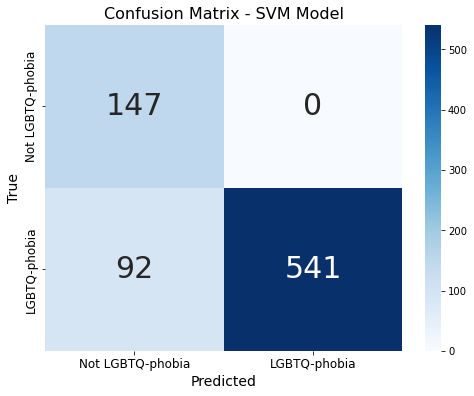

In [49]:
#Calculate the confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix for SVM:")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories, annot_kws={"size": 30})
plt.xlabel('Predicted', fontsize=14)  # Increase font size of x-axis label
plt.ylabel('True', fontsize=14)  # Increase font size of y-axis label
plt.title('Confusion Matrix - SVM Model', fontsize=16)  # Increase font size of title
plt.xticks(fontsize=12)  # Increase font size of x-axis tick labels
plt.yticks(fontsize=12)  # Increase font size of y-axis tick labels
plt.show()

# Preprocessing the lyrics data

In [50]:
# Importing the lyrics  
path_lyrics="lyrics_top_songs_dataset.csv"

#Dataframe creation 
df_lyrics = pd.read_csv(path_lyrics)

#Dataframe creation of subset with homophobic songs
df_lyrics2 = pd.read_csv(path_lyrics)

In [51]:
df_lyrics.head()

,title,tag,artist,year,views,lyrics,language
0,Stand by Me,rb,Ben E. King,1960,1590384,When the night has come\nAnd the land is dark\...,en
1,Georgia On My Mind,rock,Ray Charles,1960,188333,Georgia\nGeorgia\nThe whole day through\n(The ...,en
2,At Last,rb,Etta James,1960,176380,At last\nMy love has come along\nMy lonely day...,en
3,Wonderful World,pop,Sam Cooke,1960,85354,Don't know much about history\nDon't know much...,en
4,Are You Lonesome Tonight?,pop,Elvis Presley,1960,72279,Are you lonesome tonight? Do you miss me tonig...,en


In [52]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62999 entries, 0 to 62998
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     62999 non-null  object
 1   tag       62999 non-null  object
 2   artist    62999 non-null  object
 3   year      62999 non-null  int64 
 4   views     62999 non-null  int64 
 5   lyrics    62999 non-null  object
 6   language  62999 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.4+ MB


In [53]:
df_lyrics = df_lyrics[:]

In [54]:
df_lyrics["lyrics_original"] = df_lyrics["lyrics"]

In [55]:
# Apply function to split lyrics into sentences and create new rows
new_df = df_lyrics['lyrics'].str.split('\n', expand=True).stack().reset_index(level=1, drop=True).to_frame('lyrics')
new_df = df_lyrics.drop('lyrics', axis=1).join(new_df).reset_index(drop=True)

new_df.head()

,title,tag,artist,year,views,language,lyrics_original,lyrics
0,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,When the night has come
1,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,And the land is dark
2,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,And the moon is the only light we'll see
3,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"No, I won't be afraid"
4,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"Oh, I won't be afraid"


In [56]:
df_lyrics = new_df

In [57]:
#preprocessing lyrics

def preprocess_lyrics(text):
    if isinstance(text, str):
        sentences = text.split("\n")
        sentences = [sent.lower() for sent in sentences]  # Convert to lowercase
        sentences = [re.sub(r"[^a-zA-Z0-9_ \n]", "", sent) for sent in sentences]  # Remove non-alphanumeric characters
        
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        
        lemmatized_sentences = []
        for sent in sentences:
            words = word_tokenize(sent)  # Tokenize into words
            lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stop words
            lemmatized_sentences.append(" ".join(lemmatized_words))  # Join the lemmatized words
            
        return ' '.join(lemmatized_sentences)  # Join the preprocessed sentences into a single string

# Preprocess lyrics
df_lyrics['lyrics'] = df_lyrics['lyrics'].apply(preprocess_lyrics)
df_lyrics.dropna(subset=['lyrics'], inplace=True)


In [58]:
df_lyrics.head()

,title,tag,artist,year,views,language,lyrics_original,lyrics
0,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,night come
1,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,land dark
2,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,moon light well see
3,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,wont afraid
4,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,oh wont afraid


In [59]:
df_lyrics['lyrics'] = df_lyrics['lyrics'].apply(lambda x: x.split())

In [60]:
df_lyrics.head()

,title,tag,artist,year,views,language,lyrics_original,lyrics
0,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"[night, come]"
1,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"[land, dark]"
2,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"[moon, light, well, see]"
3,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"[wont, afraid]"
4,Stand by Me,rb,Ben E. King,1960,1590384,en,When the night has come\nAnd the land is dark\...,"[oh, wont, afraid]"


In [61]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637249 entries, 0 to 3637248
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   title            object
 1   tag              object
 2   artist           object
 3   year             int64 
 4   views            int64 
 5   language         object
 6   lyrics_original  object
 7   lyrics           object
dtypes: int64(2), object(6)
memory usage: 222.0+ MB


# Create a sample set

In [70]:
# Define a list of the desired songs along with their artists
list_songs = [
    'Johnny I Hardly Knew You - The Clancy Brothers & Tommy Makem',
    'Lyndon Johnson Told the Nation - Tom Paxton',
    'Dinosaur - Hank Williams Jr.',
    'The Lusty Month Of May - Frederick Loewe',
    'Have Yourself a Merry Little Christmas - Ella Fitzgerald',
    'April Anne - John Phillips',
    'Real Men - Joe Jackson',
    'Ur So Gay - Katy Perry',
    'Grow a Pear - Kesha',
    'Born This Way - Lady Gaga',
    'Punks Jump Up To Get Beat Down - Brand Nubian',
    'Cowards in Compton - Luke',
    'Criminal - Eminem',
    'Radicals - Tyler, The Creator',
    'I’m Not Gay - J Pee',
    'Like Home - Eminem',
    'Song 33 - Noname',
    'New World Order - Tom MacDonald & Adam Calhoun',
    'He Was Too Good To Me - Nina Simone',
    'Aint Nobody Straight in L.A. - The Miracles',
    'Stronger Than Me - Amy Winehouse',
    'SUN GOES DOWN - Lil Nas X',
    'New York - Sex Pistols',
    'Homo-Sexual - Angry Samoans',
    'I’m Not a Loser - Descendents',
    'Money for Nothing - Dire Straits'
]

# Extract the song titles from the desired songs list
desired_titles = [song.split(" - ")[0] for song in list_songs]

# Extract the artists from the desired songs list
desired_artists = [song.split(" - ")[1] for song in list_songs]

# Filter the DataFrame based on the desired songs and artists
filtered_lyrics_unigram = df_lyrics[df_lyrics['title'].isin(desired_titles) & df_lyrics['artist'].isin(desired_artists)]
filtered_lyrics_svm = filtered_lyrics_unigram
# Print the filtered DataFrame
filtered_lyrics_unigram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1547 entries, 3069 to 3624108
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1547 non-null   object
 1   tag              1547 non-null   object
 2   artist           1547 non-null   object
 3   year             1547 non-null   int64 
 4   views            1547 non-null   int64 
 5   language         1547 non-null   object
 6   lyrics_original  1547 non-null   object
 7   lyrics           1547 non-null   object
 8   predictions_SVM  1547 non-null   object
dtypes: int64(2), object(7)
memory usage: 120.9+ KB


# Apply Unigram to the sample set

In [1571]:
#UNIGRAM on lyrics
corpus_train = df_train['test_case'].apply(' '.join).tolist()
corpus_filtered_lyrics = filtered_lyrics_unigram['lyrics'].apply(' '.join).tolist()


# Create unigram model using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))  # Unigram model
X_train_unigram = vectorizer.fit_transform(corpus_train)
X_lyrics_unigram_filtered = vectorizer.transform(corpus_filtered_lyrics)

y_test_pred_unigram = clf_unigram.predict(X_lyrics_unigram_filtered)
# Access the predicted values as a list
predictions_u = y_test_pred_unigram.tolist()
filtered_lyrics_unigram["predictions_unigram"] = predictions_u


/var/folders/pd/q3rxndk502g91bc64l0j1pw80000gn/T/ipykernel_42152/4264203112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lyrics_unigram["predictions_unigram"] = predictions_u


In [1575]:
# Group the rows by song title, artist, and year
grouped = filtered_lyrics_unigram.groupby(['title', 'artist', 'year','tag'])

# Initialize lists to store the combined lyrics, predictions, year, and lyrics_original
combined_lyrics = []
combined_predictions = []
sentence_counts = []
years = []
lyrics_original = []
tag = []

# Iterate over the groups and combine the lyrics, predictions, calculate the sentence counts, and store year and lyrics_original
for group, data in grouped:
    lyrics2 = data['lyrics'].tolist()
    predictions = data['predictions_unigram'].tolist()
    combined_lyrics.append([lyric for sublist in lyrics2 for lyric in sublist])
    if 'LGBTQ-phobia' in predictions:
        combined_predictions.append('LGBTQ-phobia')
        sentence_count = sum([len(sublist) for sublist in lyrics2])
        sentence_counts.append(sentence_count)
    else:
        combined_predictions.append('Not LGBTQ-phobia')
        sentence_counts.append(0)
    years.append(group[2])
    tag.append(group[3])
    lyrics_original.append(data['lyrics_original'].iloc[0])

# Create a new DataFrame with the combined data
combined_data_u = pd.DataFrame({
    'title': [group[0] for group in grouped.groups.keys()],
    'artist': [group[1] for group in grouped.groups.keys()],
    'year': years,
    'tag': tag,
    'combined_lyrics': combined_lyrics,
    'combined_predictions_unigram': combined_predictions,
    'sentence_counts': sentence_counts,
    'lyrics_original': lyrics_original
})

# Output the combined data
combined_data_u.head(25)


,title,artist,year,tag,combined_lyrics,combined_predictions_unigram,sentence_counts,lyrics_original
0,Aint Nobody Straight in L.A.,The Miracles,1975,rb,"[aint, nobody, straight, la, seems, everybody,...",LGBTQ-phobia,158,Ain't nobody straight in L.A\nIt seems that ev...
1,April Anne,John Phillips,1970,pop,"[april, anne, red, bandanna, round, head, pret...",Not LGBTQ-phobia,0,April Anne with the red bandanna round her hea...
2,Born This Way,Lady Gaga,2011,pop,"[doesnt, matter, love, capital, put, paw, caus...",LGBTQ-phobia,328,"It doesn't matter if you love him, or capital ..."
3,Cowards in Compton,Luke,1993,rap,"[uh, yo, fuck, as, nigga, let, tell, yall, one...",LGBTQ-phobia,570,UH! Yo fuck ass niggas\nLet me tell y'all one ...
4,Criminal,Eminem,2000,rap,"[lot, people, ask, stupid, fuckin, question, l...",LGBTQ-phobia,689,A lot of people ask me stupid fuckin' question...
5,Dinosaur,Hank Williams Jr.,1980,country,"[hey, man, aint, high, heel, sneaker, sure, do...",Not LGBTQ-phobia,0,Hey man them ain't high heel sneakers\nAnd the...
6,Grow a Pear,Kesha,2010,pop,"[last, night, enough, put, brake, could, tell,...",Not LGBTQ-phobia,0,"Last night, I had enough of you\nI put on the ..."
7,Have Yourself a Merry Little Christmas,Ella Fitzgerald,1960,pop,"[merry, little, christmas, let, heart, light, ...",LGBTQ-phobia,67,"Have yourself a merry little Christmas, let yo..."
8,He Was Too Good To Me,Nina Simone,1962,rb,"[good, get, along, close, stood, everything, m...",LGBTQ-phobia,71,He was too good to me\nHow can I get along now...
9,Homo-Sexual,Angry Samoans,1982,rock,"[homosexual, screw, wife, behind, tell, kid, y...",LGBTQ-phobia,85,(Homosexual!)\n\nScrew your wife in the behind...


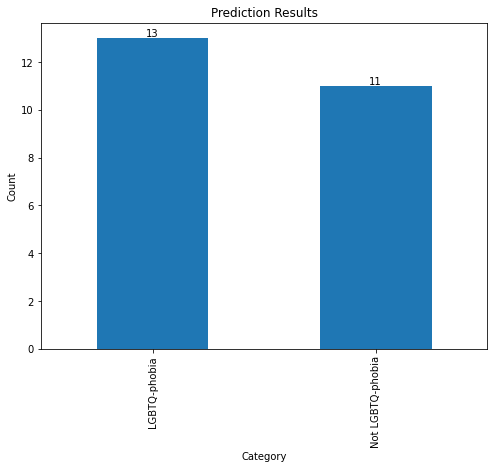

In [1576]:
# Calculate the total count of songs for each prediction
category_counts = combined_data_u['combined_predictions_unigram'].value_counts()

# Create a bar plot to visualize the prediction results
plt.figure(figsize=(8, 6))
bars = category_counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Prediction Results')

# Add counts on top of the bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# Apply SVM to the sample set

In [71]:
# Feature extraction: Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
X_val = vectorizer.transform(val_sentences)
X_test = vectorizer.transform(test_sentences)


# Splitting the data
y_train = df_train_balanced['category']
y_val = df_val['category']
y_test = df_test['category']

# Train the SVM model with sigmoid kernel
svm_label = SVC(kernel='sigmoid')
svm_label.fit(X_train, y_train)

# Predict labels for the test set
y_test_pred = svm_label.predict(X_test)

# Calculate evaluation metrics for the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the metrics for the linear kernel
print("Test Set Metrics (Kernel: linear):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Test Set Metrics (Kernel: linear):
Accuracy: 0.8794871794871795
Precision: 0.926492180019151
Recall: 0.8794871794871795
F1 Score: 0.8892525299548275


In [72]:
#SVM on test lyrics
corpus_lyrics = filtered_lyrics_svm['lyrics'].apply(' '.join).tolist()

X_filtered_lyrics = vectorizer.transform(corpus_lyrics)

# Predict labels using the trained SVM model
y_new_pred_X_filtered_lyrics = svm_label.predict(X_filtered_lyrics)


# Access the predicted values as a list
predictions_filtered_lyrics = y_new_pred_X_filtered_lyrics.tolist()
filtered_lyrics_svm["predictions_SVM"] = predictions_filtered_lyrics

/var/folders/pd/q3rxndk502g91bc64l0j1pw80000gn/T/ipykernel_70035/2996278983.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_lyrics_svm["predictions_SVM"] = predictions_filtered_lyrics


In [73]:
# Group the rows by song title, artist, and year
grouped = filtered_lyrics_svm.groupby(['title', 'artist', 'year','tag'])

# Initialize lists to store the combined lyrics, predictions, year, and lyrics_original
combined_lyrics = []
combined_predictions = []
sentence_counts = []
years = []
lyrics_original = []
tag = []

# Iterate over the groups and combine the lyrics, predictions, calculate the sentence counts, and store year and lyrics_original
for group, data in grouped:
    lyrics2 = data['lyrics'].tolist()
    predictions = data['predictions_SVM'].tolist()
    combined_lyrics.append([lyric for sublist in lyrics2 for lyric in sublist])
    if 'LGBTQ-phobia' in predictions:
        combined_predictions.append('LGBTQ-phobia')
        sentence_count = sum([len(sublist) for sublist in lyrics2])
        sentence_counts.append(sentence_count)
    else:
        combined_predictions.append('Not LGBTQ-phobia')
        sentence_counts.append(0)
    years.append(group[2])
    tag.append(group[3])
    lyrics_original.append(data['lyrics_original'].iloc[0])

# Create a new DataFrame with the combined data
combined_data_svm = pd.DataFrame({
    'title': [group[0] for group in grouped.groups.keys()],
    'artist': [group[1] for group in grouped.groups.keys()],
    'year': years,
    'tag': tag,
    'combined_lyrics': combined_lyrics,
    'combined_predictions_SVM': combined_predictions,
    'sentence_counts': sentence_counts,
    'lyrics_original': lyrics_original
})

# Output the combined data
combined_data_svm.head(25)


,title,artist,year,tag,combined_lyrics,combined_predictions_SVM,sentence_counts,lyrics_original
0,Aint Nobody Straight in L.A.,The Miracles,1975,rb,"[aint, nobody, straight, la, seems, everybody,...",LGBTQ-phobia,158,Ain't nobody straight in L.A\nIt seems that ev...
1,April Anne,John Phillips,1970,pop,"[april, anne, red, bandanna, round, head, pret...",LGBTQ-phobia,108,April Anne with the red bandanna round her hea...
2,Born This Way,Lady Gaga,2011,pop,"[doesnt, matter, love, capital, put, paw, caus...",LGBTQ-phobia,328,"It doesn't matter if you love him, or capital ..."
3,Cowards in Compton,Luke,1993,rap,"[uh, yo, fuck, as, nigga, let, tell, yall, one...",LGBTQ-phobia,570,UH! Yo fuck ass niggas\nLet me tell y'all one ...
4,Criminal,Eminem,2000,rap,"[lot, people, ask, stupid, fuckin, question, l...",LGBTQ-phobia,689,A lot of people ask me stupid fuckin' question...
5,Dinosaur,Hank Williams Jr.,1980,country,"[hey, man, aint, high, heel, sneaker, sure, do...",LGBTQ-phobia,128,Hey man them ain't high heel sneakers\nAnd the...
6,Grow a Pear,Kesha,2010,pop,"[last, night, enough, put, brake, could, tell,...",Not LGBTQ-phobia,0,"Last night, I had enough of you\nI put on the ..."
7,Have Yourself a Merry Little Christmas,Ella Fitzgerald,1960,pop,"[merry, little, christmas, let, heart, light, ...",LGBTQ-phobia,67,"Have yourself a merry little Christmas, let yo..."
8,He Was Too Good To Me,Nina Simone,1962,rb,"[good, get, along, close, stood, everything, m...",LGBTQ-phobia,71,He was too good to me\nHow can I get along now...
9,Homo-Sexual,Angry Samoans,1982,rock,"[homosexual, screw, wife, behind, tell, kid, y...",LGBTQ-phobia,85,(Homosexual!)\n\nScrew your wife in the behind...


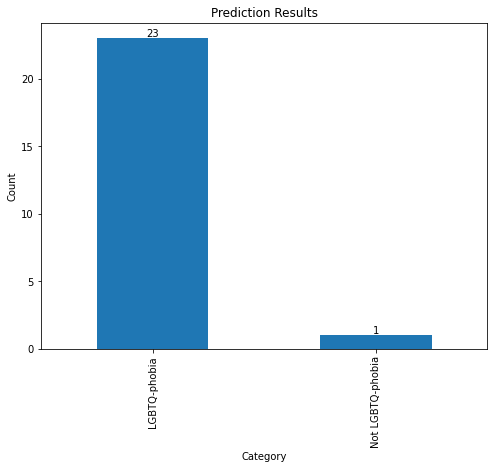

In [74]:
# Calculate the total count of songs for each prediction
category_counts = combined_data_svm['combined_predictions_SVM'].value_counts()

# Create a bar plot to visualize the prediction results
plt.figure(figsize=(8, 6))
bars = category_counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Prediction Results')

# Add counts on top of the bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# Applying unigram model on lyrics

In [1396]:
#UNIGRAM on lyrics
corpus_train = df_train['test_case'].apply(' '.join).tolist()
corpus_lyrics = df_lyrics['lyrics'].apply(' '.join).tolist()


# Create unigram model using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1))  # Unigram model
X_train_unigram = vectorizer.fit_transform(corpus_train)
X_lyrics_unigram = vectorizer.transform(corpus_lyrics)

y_test_pred_unigram = clf_unigram.predict(X_lyrics_unigram)

In [1397]:
# Access the predicted values as a list
predictions = y_test_pred_unigram.tolist()

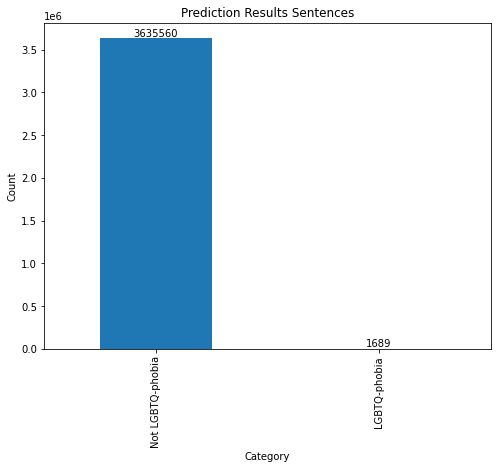

In [1398]:
# Count the number of predictions in each category
category_counts = pd.Series(predictions).value_counts()

# Create a bar plot to visualize the prediction results
plt.figure(figsize=(8, 6))
bars = category_counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Prediction Results Sentences')

# Add counts on top of the bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [1399]:
lyrics["predictions"] = predictions

In [1400]:
# Group the rows by song title, artist, and year
grouped = lyrics.groupby(['title', 'artist', 'year','tag'])

# Initialize lists to store the combined lyrics, predictions, year, and lyrics_original
combined_lyrics = []
combined_predictions = []
sentence_counts = []
years = []
lyrics_original = []
tag = []

# Iterate over the groups and combine the lyrics, predictions, calculate the sentence counts, and store year and lyrics_original
for group, data in grouped:
    lyrics2 = data['lyrics'].tolist()
    predictions = data['predictions'].tolist()
    combined_lyrics.append([lyric for sublist in lyrics2 for lyric in sublist])
    if 'LGBTQ-phobia' in predictions:
        combined_predictions.append('LGBTQ-phobia')
        sentence_count = sum([len(sublist) for sublist in lyrics2])
        sentence_counts.append(sentence_count)
    else:
        combined_predictions.append('Not LGBTQ-phobia')
        sentence_counts.append(0)
    years.append(group[2])
    tag.append(group[3])
    lyrics_original.append(data['lyrics_original'].iloc[0])

# Create a new DataFrame with the combined data
combined_data = pd.DataFrame({
    'title': [group[0] for group in grouped.groups.keys()],
    'artist': [group[1] for group in grouped.groups.keys()],
    'year': years,
    'tag': tag,
    'combined_lyrics': combined_lyrics,
    'combined_predictions': combined_predictions,
    'sentence_counts': sentence_counts,
    'lyrics_original': lyrics_original
})

# Output the combined data
combined_data.head()


,title,artist,year,tag,combined_lyrics,combined_predictions,sentence_counts,lyrics_original
0,$$$,XXXTENTACION & Matt Ox,2017,rap,"[pew, get, money, yeah, yeah, get, money, yeah...",Not LGBTQ-phobia,0,"Pew\nGet money, yeah yeah\nGet money, yeah, ge..."
1,$100 Dollar Bill Yall,Ice Cube,2001,rap,"[get, number, get, name, thick, dame, headhunt...",Not LGBTQ-phobia,0,"Get numbers, get names\nThick dames\nHeadhunte..."
2,$29.00,Tom Waits,1978,rock,"[little, black, girl, red, dress, hot, night, ...",Not LGBTQ-phobia,0,Little black girl in a red dress on a hot nigh...
3,$ave Dat Money,Lil Dicky,2015,rap,"[ld, aka, independent, variable, trap, god, se...",Not LGBTQ-phobia,0,"LD, AKA The Independent Variable\nTrap God, I ..."
4,$outh $ide $uicide,$UICIDEBOY$,2015,rap,"[outside, black, ride, tint, rolled, im, high,...",Not LGBTQ-phobia,0,"Outside in an all black ride, tint rolled up w..."


In [1401]:
sorted_data = combined_data.sort_values(by='sentence_counts', ascending=False)
sorted_data.head()

,title,artist,year,tag,combined_lyrics,combined_predictions,sentence_counts,lyrics_original
5022,Beasts Of No Nation,Fela Kuti & Egypt 80,1989,pop,"[ah, let, get, another, underground, spiritual...",LGBTQ-phobia,770,"Ah, let's get now into another underground spi..."
10756,Cross the Country,Migos,2014,rap,"[long, time, coming, young, nigga, young, rich...",LGBTQ-phobia,738,It's been a long time coming\nFrom young nigga...
42203,Remember the Titans,Joe Budden,2010,rap,"[yeah, yeah, nigga, losing, mind, find, there,...",LGBTQ-phobia,721,"Yeah, yeah\nThese niggas losing their minds, y..."
6651,Body Rott,Bone Thugs-N-Harmony,1997,rap,"[say, war, shouldnt, stop, playerhatin, nigga,...",LGBTQ-phobia,719,"I say, the war shouldn't stop until these play..."
60115,Wicked Ways,Eminem,2013,rap,"[im, getting, wicked, way, im, loading, im, ta...",LGBTQ-phobia,698,I'm getting by with my wicked ways\nI'm loadin...


In [1402]:
sorted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62999 entries, 5022 to 62998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 62999 non-null  object
 1   artist                62999 non-null  object
 2   year                  62999 non-null  int64 
 3   tag                   62999 non-null  object
 4   combined_lyrics       62999 non-null  object
 5   combined_predictions  62999 non-null  object
 6   sentence_counts       62999 non-null  int64 
 7   lyrics_original       62999 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.3+ MB


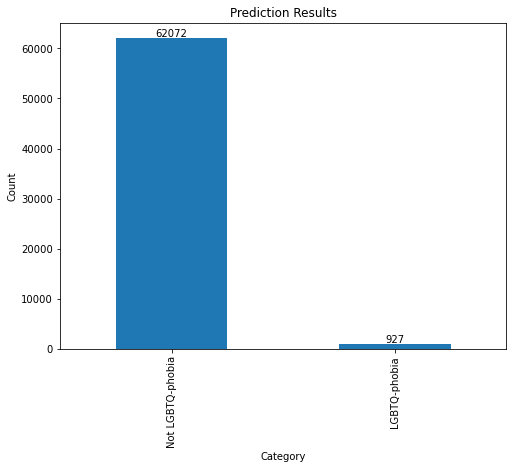

In [1403]:
# Calculate the total count of songs for each prediction
category_counts = sorted_data['combined_predictions'].value_counts()

# Create a bar plot to visualize the prediction results
plt.figure(figsize=(8, 6))
bars = category_counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Prediction Results')

# Add counts on top of the bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

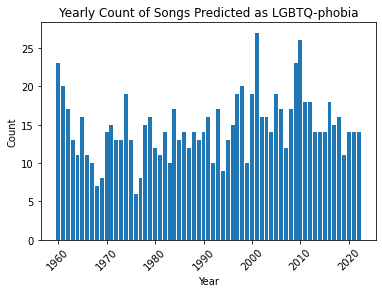

In [925]:
# Group the data by year and count the occurrences of LGBTQ-phobia predictions
grouped = sorted_data[sorted_data['combined_predictions'] == 'LGBTQ-phobia'].groupby('year').size()

# Create the bar plot
plt.bar(grouped.index, grouped.values)

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Count of Songs Predicted as LGBTQ-phobia')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

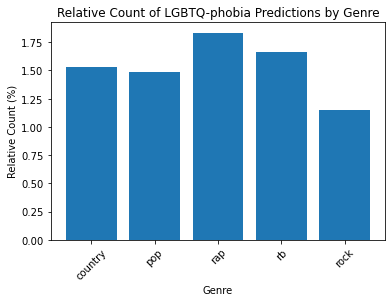

In [926]:
# Calculate the total count of songs for each genre
genre_counts = sorted_data['tag'].value_counts()

# Group the data by genre and count the occurrences of LGBTQ-phobia predictions
grouped_genre = sorted_data[sorted_data['combined_predictions'] == 'LGBTQ-phobia'].groupby('tag').size()

# Calculate the relative count by dividing the count of LGBTQ-phobia predictions by the total count for each genre
relative_counts = grouped_genre / genre_counts * 100  # Multiply by 100 for percentage values

# Create the bar plot
plt.bar(relative_counts.index, relative_counts.values)

# Set the labels and title
plt.xlabel('Genre')
plt.ylabel('Relative Count (%)')
plt.title('Relative Count of LGBTQ-phobia Predictions by Genre')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()